# Univariate LSTM

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# fix tensorflow gpu problems
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# check gpu support
gpus = tf.config.list_physical_devices('GPU')
print(len(gpus))
print(tf.test.is_built_with_gpu_support())
print(tf.test.is_built_with_cuda())
print(tf.test.gpu_device_name())

1
True
True
/device:GPU:0


## 1. Load the Dataset

In [4]:
df = pd.read_csv('Lumos5G-v1.0.csv',
                index_col=['run_num', 'seq_num'])
df.head(5)

abstractSignalStr   latitude  longitude  movingSpeed  \
run_num seq_num                                                         
1       1.0                      2  44.975314 -93.259316     0.094889   
        2.0                      2  44.975311 -93.259311     0.876634   
        3.0                      2  44.975305 -93.259292     2.225798   
        4.0                      2  44.975293 -93.259258     3.180726   
        5.0                      2  44.975278 -93.259214     3.751234   

                 compassDirection        nrStatus  lte_rssi  lte_rsrp  \
run_num seq_num                                                         
1       1.0                   150  NOT_RESTRICTED     -61.0       -94   
        2.0                   117  NOT_RESTRICTED     -61.0       -94   
        3.0                   113  NOT_RESTRICTED     -61.0       -94   
        4.0                   114  NOT_RESTRICTED     -59.0       -95   
        5.0                   115  NOT_RESTRICTED     -59.0       -95   

                 lte_rsrq     lte_rssnr  nr_ssRsrp  nr_ssRsrq  nr_ssSinr  \
run_num seq_num                                                            
1       1.0         -14.0  2.147484e+09        NaN        NaN        NaN   
        2.0         -14.0  2.147484e+09        NaN        NaN        NaN   
        3.0         -14.0  2.147484e+09        NaN        NaN        NaN   
        4.0         -16.0  2.147484e+09        NaN        NaN        NaN   
        5.0         -16.0  2.147484e+09        NaN        NaN        NaN   

                 Throughput mobility_mode trajectory_direction  tower_id  
run_num seq_num                                                           
1       1.0              78       driving                   CW        16  
        2.0             117       driving                   CW        16  
        3.0             110       driving                   CW        16  
        4.0             108       driving                   CW        16  
        5.0             100       driving                   CW        16

In [5]:
# select columns
ndf = df[["Throughput"]]
ndf.head()

Throughput
run_num seq_num            
1       1.0              78
        2.0             117
        3.0             110
        4.0             108
        5.0             100

In [6]:
max_throughput = ndf.max()
min_throughput = ndf.min()
print(f'Max throughput: {max_throughput}')
print(f'Min throughput: {min_throughput}')
max_throughput = max_throughput.item() # get python int!

Max throughput: Throughput    1920
dtype: int64
Min throughput: Throughput    0
dtype: int64


In [7]:
# Min-Max Scaling
df=(ndf-ndf.min())/(ndf.max()-ndf.min())
df.head()

Throughput
run_num seq_num            
1       1.0        0.040625
        2.0        0.060937
        3.0        0.057292
        4.0        0.056250
        5.0        0.052083

## 2. Create Train-Test Sets

In [8]:
# split function into sequences
def multistep_split(seq, n_steps_in, n_steps_out):
    X = list()
    y = list()
    for i in range(len(seq)):
        # pattern end
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(seq):
            break
        seq_x = seq[i:end_ix]
        seq_y = seq[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [9]:
# separately splits runs into sequences
run_max=df.index.max()[0]
seconds_in = 20 # previous steps
seconds_out = 10 # forecast steps
X_list = list()
y_list = list()
for run_num in range(1, run_max+1):
    run = df.loc[run_num].values
    X, y = multistep_split(run.astype('float32'), n_steps_in=seconds_in, n_steps_out=seconds_out)
    X_list.append(X)
    y_list.append(y)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
X = X.reshape((X.shape[0], X.shape[1]))
print(X.shape)
print(y.shape)

(64696, 20)
(64696, 10)


In [10]:
ratio=0.8
train_size = int(ratio*X.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(51756, 20)
(51756, 10)
(12940, 20)
(12940, 10)


In [11]:
# reshape inputs into 3d 
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## 3. Simple LSTM

In [12]:
def simple_lstm(seconds_in, seconds_out, lr=0.0001, ls='mean_squared_error'):
    # define layers
    inputs = tf.keras.Input(shape=(seconds_in, 1))
    lstm = tf.keras.layers.LSTM(128, activation='tanh')
    dense1 = tf.keras.layers.Dense(128, activation='relu')
    outputs = tf.keras.layers.Dense(seconds_out, activation='linear')
    layers = [inputs, lstm, dense1, outputs]
    # create model
    model = tf.keras.Sequential(layers)
    model.summary()
    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    rmse = tf.keras.metrics.RootMeanSquaredError()
    mae = tf.keras.metrics.MeanAbsoluteError()
    model.compile(optimizer=opt, loss=ls, metrics=[rmse, mae])
    return model

## 4. Stacked LSTM

In [13]:
def stacked_lstm(seconds_in, seconds_out, lr=0.0001, ls='mean_squared_error'):
    # define layers
    inputs = tf.keras.Input(shape=(seconds_in, 1))
    lstm1 = tf.keras.layers.LSTM(32, activation='tanh',
                                 return_sequences=True)
    lstm2 = tf.keras.layers.LSTM(32, activation='tanh')
    dense1 = tf.keras.layers.Dense(64, activation='relu')
    outputs = tf.keras.layers.Dense(seconds_out, activation='linear')
    layers = [inputs, lstm1, lstm2, dense1, outputs]
    # create model
    model = tf.keras.models.Sequential(layers)
    model.summary()
    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    rmse = tf.keras.metrics.RootMeanSquaredError()
    mae = tf.keras.metrics.MeanAbsoluteError()
    model.compile(optimizer=opt, loss=ls, metrics=[rmse, mae])    
    return model

## 5. Encoder-Decoder LSTM

In [14]:
def encoder_decoder_lstm(seconds_in, seconds_out, lr=0.0001, ls='mean_squared_error'):
    # define layers
    inputs = tf.keras.Input(shape=(seconds_in, 1))
    encoder = tf.keras.layers.LSTM(32, activation='tanh')
    vector = tf.keras.layers.RepeatVector(seconds_out)
    decoder = tf.keras.layers.LSTM(32, activation='tanh',
                                        return_sequences=True)
    output = tf.keras.layers.Dense(1, activation='linear')
    outputs = tf.keras.layers.TimeDistributed(output)
    layers = [inputs, encoder, vector, decoder, outputs]
    # create model
    model = tf.keras.models.Sequential(layers)
    model.summary()
    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    rmse = tf.keras.metrics.RootMeanSquaredError()
    mae = tf.keras.metrics.MeanAbsoluteError()
    model.compile(optimizer=opt, loss=ls, metrics=[rmse, mae])
    return model

## 6. Bidirectional LSTM

In [15]:
def bidirectional_lstm(seconds_in, seconds_out, lr=0.0001, ls='mean_squared_error'):
    # define layers
    inputs = tf.keras.Input(shape=(seconds_in, 1))
    lstm = tf.keras.layers.LSTM(16, activation='tanh',
                                return_sequences=True)
    bidirect = tf.keras.layers.Bidirectional(lstm)
    output = tf.keras.layers.Dense(1, activation='linear')
    outputs = tf.keras.layers.TimeDistributed(output)
    layers = [inputs, bidirect, outputs]
    # create model
    model = tf.keras.models.Sequential(layers)
    model.summary()
    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    rmse = tf.keras.metrics.RootMeanSquaredError()
    mae = tf.keras.metrics.MeanAbsoluteError()
    model.compile(optimizer=opt, loss=ls, metrics=[rmse, mae])
    return model

In [16]:
model = simple_lstm(seconds_in, seconds_out, lr=0.00001, ls='mean_squared_error')
#model = stacked_lstm(seconds_in, seconds_out, lr=0.0001, ls='mean_absolute_error')
#model = encoder_decoder_lstm(seconds_in, seconds_out, lr=0.0001, ls='mean_absolute_error')
#model = bidirectional_lstm(seconds_in, seconds_out, lr=0.0001, ls='mean_absolute_error')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 84,362
Trainable params: 84,362
Non-trainable params: 0
_________________________________________________________________


## 4. Train LSTM

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0.00001,
                                                  patience=10,
                                                  verbose=0,
                                                  mode='auto',
                                                  restore_best_weights=True)
history = model.fit(X_train,y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/100
1618/1618 [==============================] - 9s 5ms/step - loss: 0.0587 - root_mean_squared_error: 0.2423 - mean_absolute_error: 0.1815 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1849 - val_mean_absolute_error: 0.1450
Epoch 2/100
1618/1618 [==============================] - 8s 5ms/step - loss: 0.0357 - root_mean_squared_error: 0.1890 - mean_absolute_error: 0.1490 - val_loss: 0.0311 - val_root_mean_squared_error: 0.1764 - val_mean_absolute_error: 0.1371
Epoch 3/100
1618/1618 [==============================] - 8s 5ms/step - loss: 0.0331 - root_mean_squared_error: 0.1819 - mean_absolute_error: 0.1410 - val_loss: 0.0295 - val_root_mean_squared_error: 0.1717 - val_mean_absolute_error: 0.1309
Epoch 4/100
1618/1618 [==============================] - 9s 5ms/step - loss: 0.0320 - root_mean_squared_error: 0.1788 - mean_absolute_error: 0.1368 - val_loss: 0.0285 - val_root_mean_squared_error: 0.1688 - val_mean_absolute_error: 0.1271
Epoch 5/100
1618/1618 [=====================

1618/1618 [==============================] - 9s 5ms/step - loss: 0.0280 - root_mean_squared_error: 0.1672 - mean_absolute_error: 0.1205 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1577 - val_mean_absolute_error: 0.1097
Epoch 36/100
1618/1618 [==============================] - 8s 5ms/step - loss: 0.0279 - root_mean_squared_error: 0.1672 - mean_absolute_error: 0.1204 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1602 - val_mean_absolute_error: 0.1138
Epoch 37/100
1618/1618 [==============================] - 8s 5ms/step - loss: 0.0280 - root_mean_squared_error: 0.1672 - mean_absolute_error: 0.1204 - val_loss: 0.0251 - val_root_mean_squared_error: 0.1585 - val_mean_absolute_error: 0.1118
Epoch 38/100
1618/1618 [==============================] - 8s 5ms/step - loss: 0.0279 - root_mean_squared_error: 0.1672 - mean_absolute_error: 0.1203 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1581 - val_mean_absolute_error: 0.1109
Epoch 39/100
1618/1618 [=============================

1618/1618 [==============================] - 9s 5ms/step - loss: 0.0277 - root_mean_squared_error: 0.1664 - mean_absolute_error: 0.1195 - val_loss: 0.0247 - val_root_mean_squared_error: 0.1571 - val_mean_absolute_error: 0.1092
Epoch 70/100
1618/1618 [==============================] - 9s 5ms/step - loss: 0.0277 - root_mean_squared_error: 0.1664 - mean_absolute_error: 0.1196 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1589 - val_mean_absolute_error: 0.1123
Epoch 71/100
1618/1618 [==============================] - 9s 5ms/step - loss: 0.0277 - root_mean_squared_error: 0.1664 - mean_absolute_error: 0.1195 - val_loss: 0.0248 - val_root_mean_squared_error: 0.1574 - val_mean_absolute_error: 0.1103
Epoch 72/100
1618/1618 [==============================] - 9s 5ms/step - loss: 0.0277 - root_mean_squared_error: 0.1663 - mean_absolute_error: 0.1196 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1578 - val_mean_absolute_error: 0.1107
Epoch 73/100
1618/1618 [=============================

Minimal Loss: 0.0246


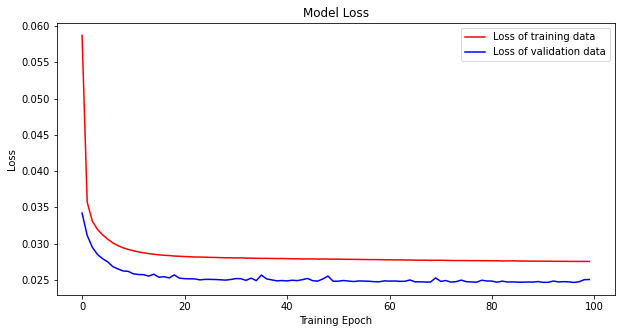

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
min_loss = min(val_loss)
print(f'Minimal Loss: {min_loss:.4f}')
plt.figure(figsize=(10,5))
plt.plot(loss, 'r', label='Loss of training data')
plt.plot(val_loss, 'b-', label='Loss of validation data')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.legend()
plt.show()

Minimal MAE 208.5 Mbps
Minimal RMSE 301.3 Mbps


<Figure size 432x288 with 0 Axes>

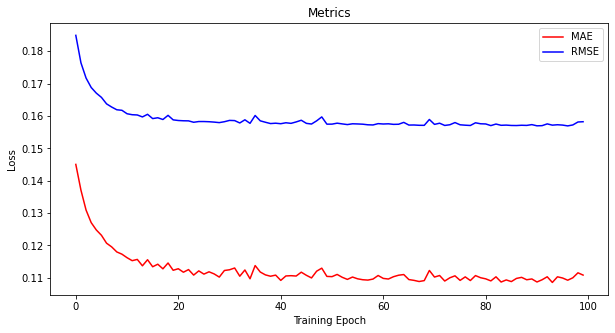

In [19]:
# MAE and RMSE plots
plt.clf() # clear the figure
mae = history.history['val_mean_absolute_error']
min_mae = min(mae)
print(f'Minimal MAE {min_mae*max_throughput:.1f} Mbps')
rmse = history.history['val_root_mean_squared_error']
min_rmse = min(rmse)
print(f'Minimal RMSE {min_rmse*max_throughput:.1f} Mbps')
plt.figure(figsize=(10,5))
plt.plot(mae, 'r', label='MAE')
plt.plot(rmse, 'b', label='RMSE')
plt.title('Metrics')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.legend()
plt.show()

## 5. Test-Prediction Comparision

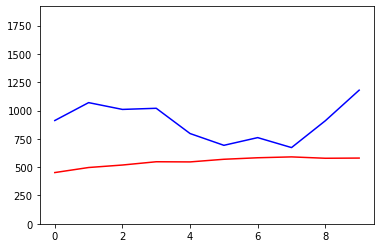

In [22]:
n = 45 # example number
y_true = y_test[n]
x_in = X_test[n].reshape((1, seconds_in, 1))
y_pred = model.predict(x_in).flatten()
plt.plot(y_true*max_throughput, 'b')
plt.plot(y_pred*max_throughput, 'r')
plt.ylim(0, max_throughput)
plt.show()